# ARMA(1,1) + GJR-GARCH(1,1) with skewed-t errors

## 1. Data simulation
In this section, we generate our true data according to the following data generating process. We assume that return of some asset at day $t$ is given by 
\begin{eqnarray} 
r_{t} &=& \mu_t + \epsilon_t\\
\mu_t &=&\phi_{0} + \phi_{1} r_{t-1} + \varphi_{1} \epsilon_{t-1} \\
\epsilon_t &=& \sigma_{t} z_{t} \\
\sigma_{t}^2 &=&  \omega + \beta  \sigma_{t-1}^2 + \alpha (\sigma_{t-1} z_{t-1})^2 + \gamma (\sigma_{t-1} z_{t-1})^2 I_{\{z_{t-1}<0\}} \label{equation:conditionalvariance}  
\end{eqnarray} where  
- $z_{t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters  denoted by $2<\nu_i<\infty$ and $-1<\lambda_i<1$, respectively.
- $\mu_i$ denotes de unconditional mean.
- $\sigma_{t}^2$ corresponds to the conditional variance which describes a GJR-GARCH model
- $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
- Positiveness restrictions: $\omega>0$, $\alpha\geq 0$, $\alpha+\gamma_i>0$ and $\beta\geq 0$ 
- Stationarity restriction:  $\alpha_i+\frac{1}{2}\gamma_i+\beta_i<1$
- $|\phi_1|<1$

The set of model parameters is $\theta=(\phi_{0},\phi_{1},\varphi_{1}, \omega, \beta, \alpha, \gamma,\nu,\lambda)$.

Moreover, the unconditional mean and variance are $$\mathbf{E}(r_{t})=\frac{\phi_{0}}{1-\phi_{1}}$$ and $$\text{var}(r_{t})=\frac{\sigma^2_{t}}{1-\phi_{1}^2}\left(1+2\phi_{1}\varphi_{1}+\varphi_{1}^2\right)$$

The following helper function named **skewtinv** computes the inverse of a skewed-t cumulative distribution function, e.g., it computes $z = F^{-1}(p|\nu,\lambda)$, where $p$ denotes a cumulative probability and $\nu$, $\lambda$ are shape parameters that controls for kurtosis and skewness, respectively. 

In [1]:
skewtinv <- function(p, nu, lambda) {
# USAGE:
#   X=skewtinv(P,V,LAMBDA)
 
# INPUTS:
#   P      - Values to be inverted, P in [0,1]
#   nu     - kurtosis parameter
#   lambda - skewness parameter 
     
# OUTPUTS:
#   X      - Skewed T distributed random variables corresponding to P

# COMMENTS:
#   nu > 2
#   -.99 < lambda < .99  
    
# REFERENCE:
#   [1] Hansen (1994), Intl.Econ.Rev. (35)

c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}

In [2]:
set.seed(12345) # for reproducibility
T <- 4000 # Number of simulated data
burn <- 200 # we drop first observations
TT <- T + burn

# Paramteres:
phi0 <- 0.035 ; phi1 <- -0.96 ; varphi1 <- 0.99  # conditional mean parameters
omega <- 0.10; beta <- 0.85; alpha <- 0.04; gamma <- 0.16 # conditional variance paramters
nu <- 3.5; lambda <- -0.1 # shape parameters
par <- c(phi0,phi1,varphi1,omega,beta,alpha,gamma,nu,lambda)

# generate TT random variables, uniformly distributed between 0 and 1:
Fdata <- runif(TT, min = 0.0001, max = 0.9999)

# obtain standardized returns, recall that Z ~ F(z|nu,lambda) where F is a skewed-t CDF:
z <- skewtinv(Fdata,nu,lambda)

# we will store the simulated conditional variance, returns and prices series here:
conMu <- replicate(TT,0)
sigma2 <- replicate(TT,0)
ret <- replicate(TT,0)
price <- replicate(TT,0)

# initial values (required to start the process):
conMu[1] <- phi0/(1-phi1)
sigma2[1] <- omega
ret[1] = phi0 + z[1]*sqrt(sigma2[1])
price[1] = 10 # arbitrary

for (t in 2 : TT)  {
    sigma2[t] <-  omega + beta*sigma2[t-1] + alpha*(z[t-1]*sqrt(sigma2[t-1]))^2 + gamma*min((z[t-1]*sqrt(sigma2[t-1])),0)^2 # GJR-GARCH(1,1) 
    conMu[t] <- phi0 + phi1*ret[t-1] + varphi1*z[t-1]*sqrt(sigma2[t-1])
    ret[t] <- conMu[t] + z[t]*sqrt(sigma2[t])
    price[t] <- price[t-1]*(1+ret[t]/100)
    }

date <- seq(as.Date("1900-01-01"),as.Date("2019-12-31"),by = 1) # arbitrary, it is a simulation!

# drop first observations (usually, first observations are not good):
truedf <- data.frame("date" = tail(date,T), 
                     "p" = tail(price,T),
                     "r" = tail(ret,T), 
                     "z" = tail(z,T), 
                     "conMu" = tail(conMu,T),
                     "sigma2" = tail(sigma2,T))

In [3]:
head(truedf)

,date,p,r,z,conMu,sigma2
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2009-01-18,12.64215,0.2356104,0.20325669,-0.06769471,2.226741
2,2009-01-19,12.82850,1.4740469,0.96604053,0.10908608,1.996410
3,2009-01-20,12.66386,-1.2834405,-0.91714206,-0.02877381,1.871473
4,2009-01-21,12.67978,0.1257631,0.07116305,0.02498286,2.005590
5,2009-01-22,12.73941,0.4702751,0.33957154,0.01403987,1.805157
6,2009-01-23,12.83411,0.7433717,0.55252602,0.03520879,1.642710


Let's take a look to the last observations of our simulated dataset:

In [4]:
tail(truedf)

,date,p,r,z,conMu,sigma2
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3995,2019-12-26,28.32032,0.10200333,-0.04759810,0.16734068,1.884274
3996,2019-12-27,27.87526,-1.57152901,-1.10662855,-0.12760718,1.702486
3997,2019-12-28,27.90107,0.09262257,-0.01538584,0.11418524,1.964095
3998,2019-12-29,27.94903,0.17189109,0.18579603,-0.07526471,1.769574
3999,2019-12-30,28.45610,1.81424760,1.34088007,0.11466879,1.606581
4000,2019-12-31,27.93235,-1.84054115,-1.44456758,-0.02409468,1.581137


Some descriptive statistics of our simulated data:

In [5]:
summary(truedf[,-1]) 
print(paste0("var(z)= ",round(var(truedf$z),4)))

       p               r                   z                 conMu         
 Min.   :12.12   Min.   :-17.59776   Min.   :-7.264076   Min.   :-0.74084  
 1st Qu.:20.94   1st Qu.: -0.59043   1st Qu.:-0.461484   1st Qu.:-0.07377  
 Median :28.89   Median :  0.08863   Median : 0.059886   Median : 0.01769  
 Mean   :28.52   Mean   :  0.03055   Mean   :-0.005174   Mean   : 0.01804  
 3rd Qu.:35.61   3rd Qu.:  0.71038   3rd Qu.: 0.515237   3rd Qu.: 0.11022  
 Max.   :47.17   Max.   : 10.32839   Max.   : 6.152402   Max.   : 0.77319  
     sigma2       
 Min.   : 0.7532  
 1st Qu.: 1.1576  
 Median : 1.5522  
 Mean   : 2.4239  
 3rd Qu.: 2.5169  
 Max.   :68.3725  

[1] "var(z)= 0.906"


In [8]:
# libraries for visualization
library(ggplot2)
library(ggpubr)

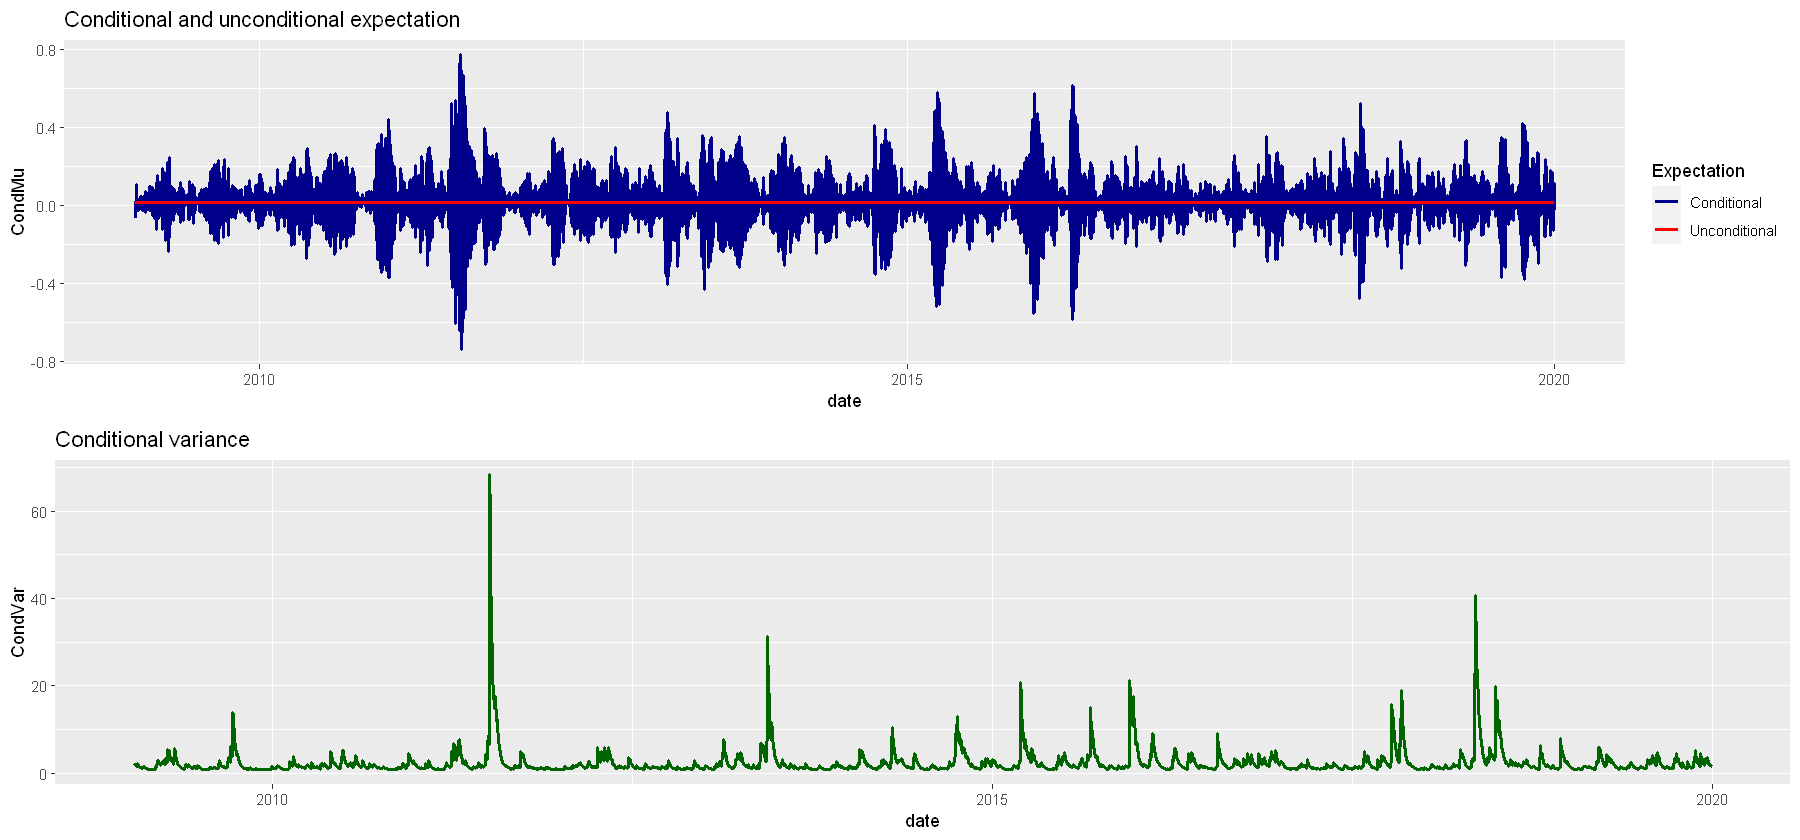

In [9]:
UncondMu <- rep((phi0/(1-phi1)),length(truedf$conMu))
plotdf <- data.frame("date"=truedf$date, "CondVar"=truedf$sigma2, "CondMu"=truedf$conMu,"UncondMu"=UncondMu) 

Expectation = c("Conditional"="darkblue","Unconditional"="red")
muplot <- ggplot(plotdf, aes(x = date)) + 
    geom_line(aes(y = CondMu, color = "Conditional"), size = 1) +
    geom_line(aes(y = UncondMu, color = "Unconditional"), size = 1) +
    labs(title = "Conditional and unconditional expectation", 
    x = "date") + 
    labs(color="Expectation") +
    scale_color_manual(values = Expectation)

varplot <- ggplot(plotdf, aes(x = date)) + 
  geom_line(aes(y = CondVar), size = 1, color = "darkgreen") +
  labs(title = "Conditional variance", 
    x = "date")

options(repr.plot.width=15, repr.plot.height=7)
figure <- ggarrange(muplot, varplot, 
                    ncol = 1, nrow = 2)

annotate_figure(figure)

Data visualization:

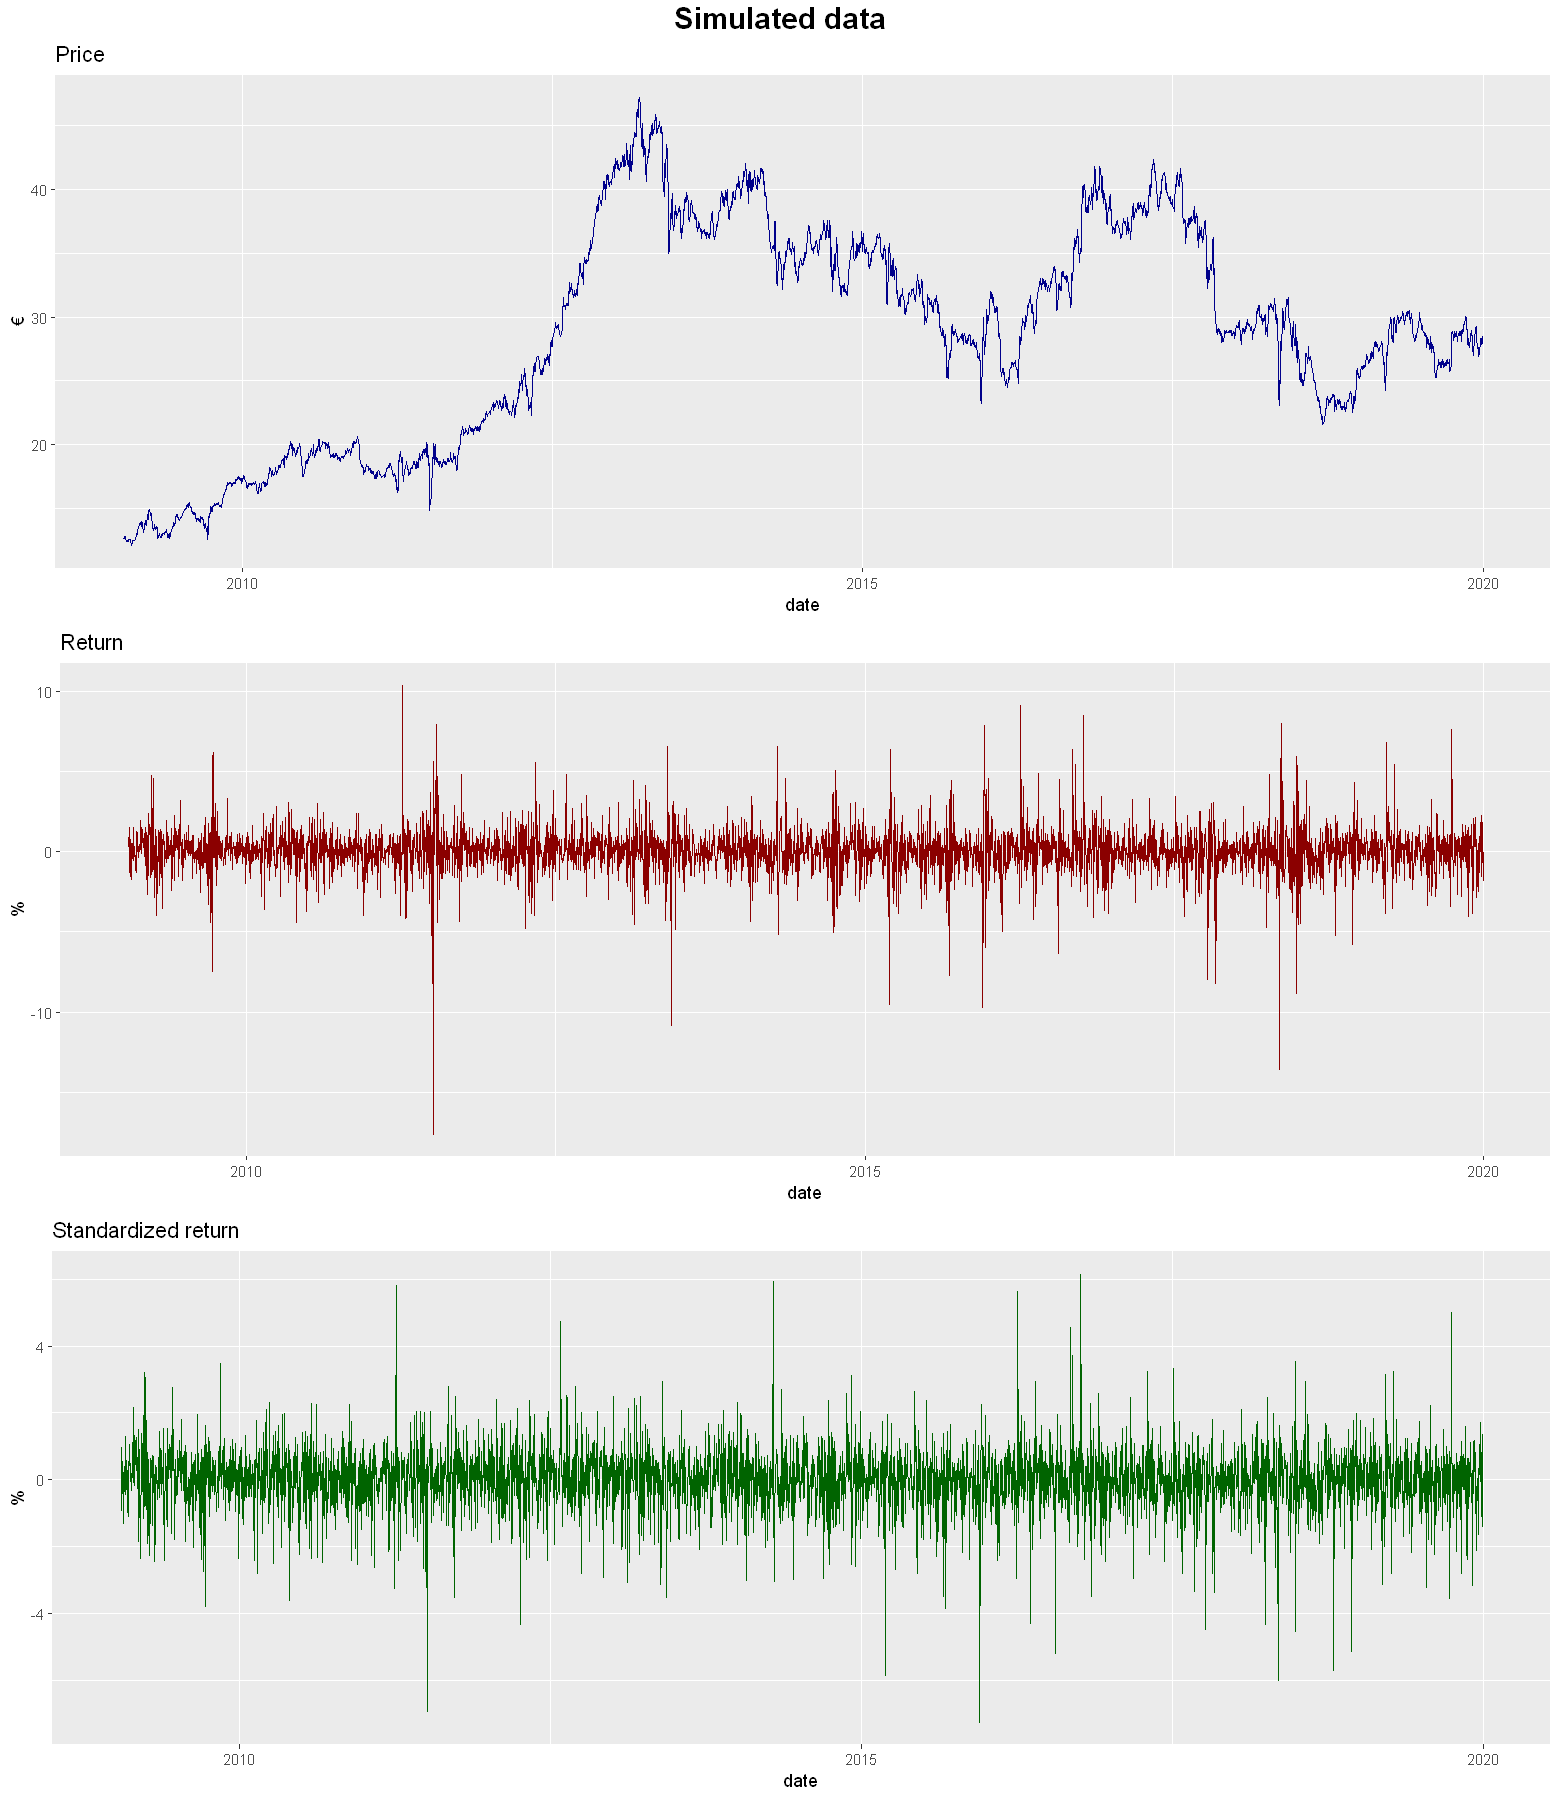

In [10]:
pplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = p), size = 0.3, color = "darkblue") +
  labs(title = "Price", 
    #subtitle = print("Total sample"),
    x = "date",
    y = "€" )

rplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = r), size = 0.3, color = "darkred") +
  labs(title = "Return", 
    x = "date",
    y = "%" )

zplot <- ggplot(truedf, aes(x = date)) + 
  geom_line(aes(y = z), size = 0.3, color = "darkgreen") +
  labs(title = "Standardized return", 
    #subtitle = print("Total sample"),
    x = "date",
    y = "%" )

options(repr.plot.width=13, repr.plot.height=15)
figure <- ggarrange(pplot, rplot, zplot, 
                    ncol = 1, nrow = 3)

annotate_figure(figure, top = text_grob("Simulated data", color = "black", face = "bold", size = 18))  

## 2. Maximum likelihood estimation
Next, we estimate the parameters of the model by maximum likelihood (ML). The ML estimator of $\theta$ is given by $$\hat{\theta} = \arg \max_{\theta}(L_{z}(\theta))= \arg \max_{\theta} \sum_{t=1}^{T}\log(f(z_{t})),$$ where $f$ denotes the skewed-t density function of Hansen (1994).

The following helper function called **ARMA_GJRloglik** computes $L_{z}(\theta)$. So that, our goal is to find the parameter set that maximizes the value of ARMA_GJRloglik, given our data.

In [11]:
ARMA_GJRloglik <- function(par, ret) {
    # Mean: ARMA(1,1)
    # Variance: GJR-GARCH(1,1)
    TT <- length(ret)
    condMu <- matrix(rep(0,TT),TT)
    sigma2 <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    
    # Starting values:
    sigma2[1] <- 1
    z[1] <- 0
    epsi[1] <- sqrt(sigma2[1])*z[1]
  
    # Conditional mean:
    a0 <- par[1] # phi0
    a1 <- par[2] # phi1
    a2 <- par[3] # varphi1
    condMu[1] <- a0/(1-a1) # unconditional mean as starting value
  
    # Conditional variance:
    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[4] # omega
    b1 <- par[5] # beta
    b2 <- par[6] # alpha
    b3 <- par[7] # gamma
    
    # ARMA(1,1) and GJR-GARCH(1,1):
    for (t in 2 : TT)  {
        sigma2[t] <-  b0 + b1*sigma2[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
        condMu[t] <- a0 + a1*ret[t-1] + a2*epsi[t-1]  # ARMA(1,1)
        z[t] <- (ret[t]-condMu[t])/sqrt(sigma2[t])   
        epsi[t] <- z[t]*sqrt(sigma2[t]) 
    }
    sigmaPrime <- sqrt(b0 + b1*tail(sigma2,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2)
    muPrime <- a0 + a1*tail(ret,1) + a2*tail(epsi,1)
    
    # Errors distribution: skewed-t (Hansen, 1994)  
    # Distribution parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
   
    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c <- exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(sigma2[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(sigma2[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
    
  return(LL)
}

Estimation:

In [12]:
# required library
library(pracma)

In [13]:
# Initial values
phi00 <- 0.01 ; phi10 <- 0.1 ; varphi10 <- -0.1  
omega0 <- 0.01 ; beta0 <- 0.9 ; alpha0 <- 0.01 ; gamma0 <- 0.01
nu0 <- 4 ; lambda0 <- - 0.2
par0 <- c(phi00, phi10, varphi10, omega0, beta0, alpha0, gamma0, nu0, lambda0) 

# Model restrictions
lb <- c(-100, -0.999, -0.999, rep(0.001,3), -10, 2.01, -0.999)  
ub <- c(100, 0.999, 0.999, rep(100,5), 0.999)                
A  <- matrix(rbind(c(0, 0, 0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, 0, 0, -1, -1, 0, 0)), 2)   
b  <- matrix(c(0.999, -0.001),2)    
Aeq  <- NULL
beq  <- NULL

# Estimation
x1 <- fmincon(x0 = par0, 
              ret = truedf$r, 
              ARMA_GJRloglik, # objective function
              ub=ub, lb=lb, 
              A=A, b=b, 
              Aeq=Aeq, beq=beq, 
              tol=1e-04)
par1 <- x1$par

# Standard errors:
hessianMatrix <- hessian(ARMA_GJRloglik, x1$par, ret=truedf$r)
se <- sqrt(diag(inv(hessianMatrix)))

# p-values:
tstat <- abs(par1/se)
pvalue <- 2*pt(tstat, df=T-1, lower.tail = FALSE) # Null: hat(par) = 0

estdf <- data.frame("true"=c(phi0,phi1,varphi1,omega,beta,alpha,gamma,nu,lambda), 
                    "MLestimate"=round(par1,3),
                    "s.e."=round(se,4),
                    "p-value"=round(pvalue,4),
                   row.names = c('phi0','phi1','varphi1','omega','beta','alpha','gamma','nu','lambda'))

print(estdf)

          true MLestimate   s.e. p.value
phi0     0.035      0.009 0.0361  0.7975
phi1    -0.960     -0.959 0.0054  0.0000
varphi1  0.990      0.988 0.0026  0.0000
omega    0.100      0.137 0.0200  0.0000
beta     0.850      0.806 0.0178  0.0000
alpha    0.040      0.066 0.0174  0.0002
gamma    0.160      0.148 0.0288  0.0000
nu       3.500      3.723 0.2314  0.0000
lambda  -0.100     -0.140 0.0212  0.0000


Log-likelihood, AIC and BIC:

In [18]:
LogLik <- - x1$value 
AIC <- 2*length(par1) - 2*LogLik 
BIC <- length(par1)*log(T) - 2*LogLik 
print(c("LL"=LogLik,"AIC"=AIC,"BIC"=BIC))

       LL       AIC       BIC 
-3141.031  6300.063  6356.709 


## 3. Empirical application (true data)

In [37]:
stock <- "^GSPC" # S&P500

t1 <- as.integer(ISOdate(2010,1,17,hour=0))
t2 <- as.integer(ISOdate(2019,11,30,hour=0))

url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
 stock,
 "?period1=",
 as.integer(t1),
 "&period2=",
 as.integer(t2),
 "&interval=1d&events=history&includeAdjustedClose=true",
 sep="")

data <- read.csv(url)
df <- data.frame(date=data$Date, price=data$Adj.Close)
df['date'] <- as.Date(df$date)

# growth rate
genretdf <- function(pricesdf) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  date <- as.Date(pricesdf$date[-1]) 
  retdf <- data.frame(date,ret)
  return(retdf)
  }

# add growth rate to the dataset
df <- merge(x=df,y=data.frame(genretdf(df)),by="date") 
head(df)

,date,price,ret
,<date>,<dbl>,<dbl>
1,2010-01-20,1138.04,-1.0654386
2,2010-01-21,1116.48,-1.9126658
3,2010-01-22,1091.76,-2.2389779
4,2010-01-25,1096.78,0.4587559
5,2010-01-26,1092.17,-0.4212058
6,2010-01-27,1097.50,0.4868283


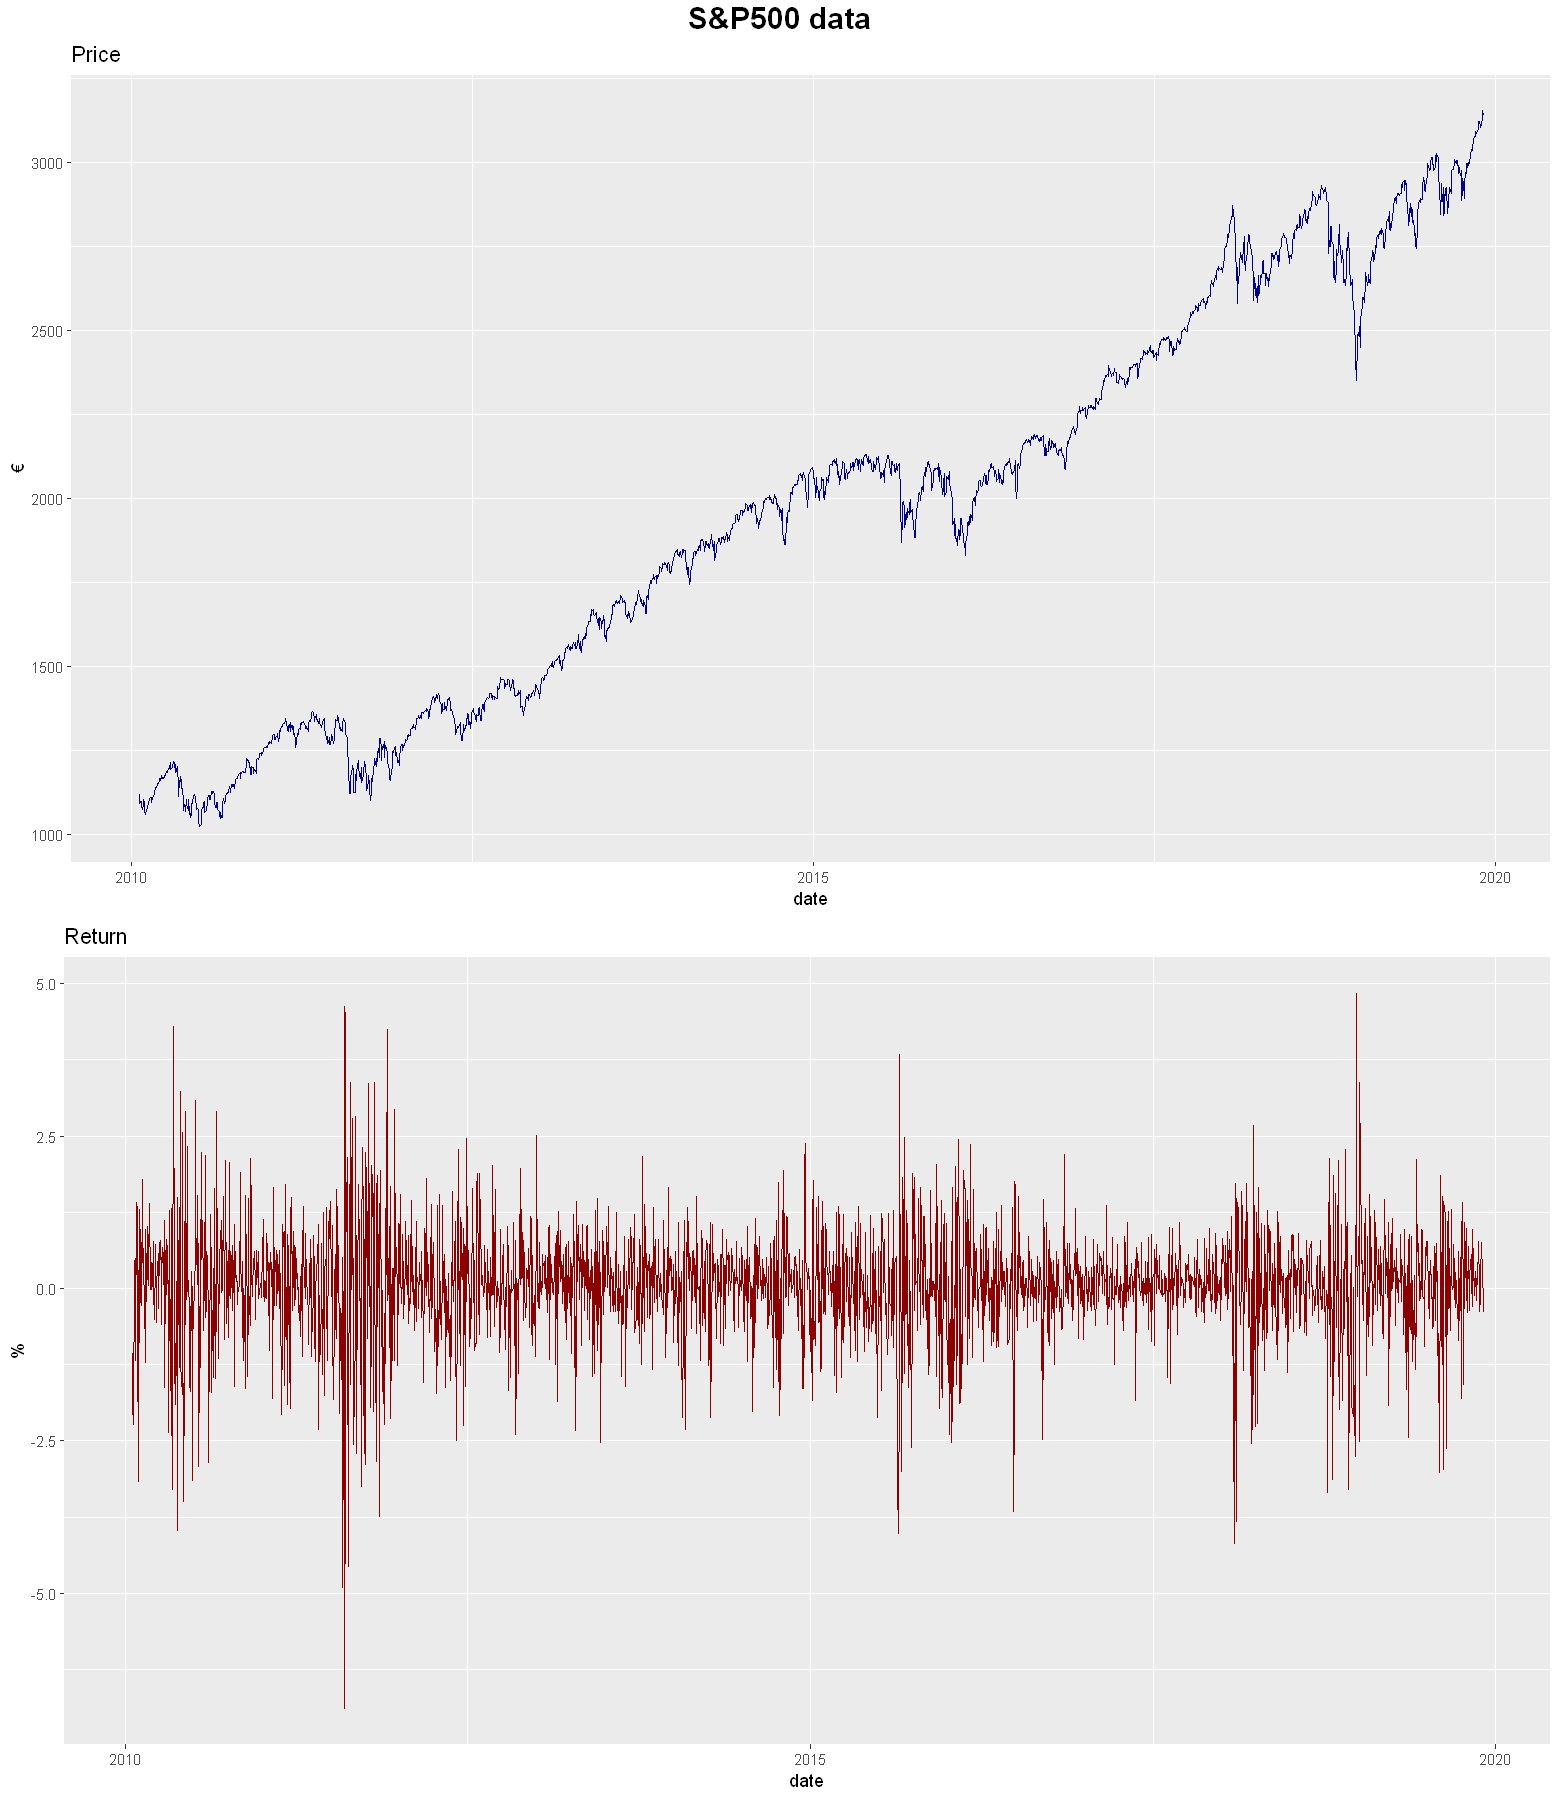

In [38]:
pplot <- ggplot(df[-1,], aes(x = date)) + 
  geom_line(aes(y = price), size = 0.3, color = "darkblue") +
  labs(title = "Price", 
    x = "date",
    y = "€" )

rplot <- ggplot(df, aes(x = date)) + 
  geom_line(aes(y = ret), size = 0.3, color = "darkred") +
  labs(title = "Return", 
    x = "date",
    y = "%" )

options(repr.plot.width=13, repr.plot.height=15)
figure <- ggarrange(pplot, rplot,
                    ncol = 1, nrow = 2)

annotate_figure(figure, top = text_grob("S&P500 data", color = "black", face = "bold", size = 18)) 

In [40]:
# Initial values
phi00 <- 0.01 ; phi10 <- 0.1 ; varphi10 <- -0.1  
omega0 <- 0.01 ; beta0 <- 0.9 ; alpha0 <- 0.01 ; gamma0 <- 0.01
nu0 <- 4 ; lambda0 <- - 0.2
par0 <- c(phi00, phi10, varphi10, omega0, beta0, alpha0, gamma0, nu0, lambda0) 

# Model restrictions
lb <- c(-100, -0.999, -0.999, rep(0.001,3), -10, 2.01, -0.999)  
ub <- c(100, 0.999, 0.999, rep(100,5), 0.999)                
A  <- matrix(rbind(c(0, 0, 0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, 0, 0, -1, -1, 0, 0)), 2)   
b  <- matrix(c(0.999, -0.001),2)    
Aeq  <- NULL
beq  <- NULL

# Estimation
x1 <- fmincon(x0 = par0, 
              ret = df$ret, 
              ARMA_GJRloglik, # objective function
              ub=ub, lb=lb, 
              A=A, b=b, 
              Aeq=Aeq, beq=beq, 
              tol=1e-04)
par1 <- x1$par

# Standard errors:
hessianMatrix <- hessian(ARMA_GJRloglik, x1$par, ret=df$ret)
se <- sqrt(diag(inv(hessianMatrix)))

# p-values:
tstat <- abs(par1/se)
pvalue <- 2*pt(tstat, df=T-1, lower.tail = FALSE) # Null: hat(par) = 0

estdf <- data.frame("MLestimate"=round(par1,3),
                    "s.e."=round(se,4),
                    "p-value"=round(pvalue,4),
                    row.names = c('phi0','phi1','varphi1','omega','beta','alpha','gamma','nu','lambda'))

print(estdf)

        MLestimate   s.e. p.value
phi0         0.014 0.0053  0.0111
phi1         0.726 0.0999  0.0000
varphi1     -0.771 0.0931  0.0000
omega        0.031 0.0051  0.0000
beta         0.820 0.0192  0.0000
alpha        0.001 0.0197  0.9595
gamma        0.291 0.0422  0.0000
nu           5.815 0.7032  0.0000
lambda      -0.151 0.0280  0.0000


### References
- Hansen, B. (1994). Autoregressive Conditional Density Estimation. International Economic Review, 35(3), 705-730. doi:10.2307/2527081
- Sheppard, K. (2021). Financial Econometrics Notes.